In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import shutil
import os

excel_reports = ".\Excel reports"
saved_models = ".\Saved models"
trained_models = ".\Trained models"

ticker = 'aapl'

#Delete folders
# shutil.rmtree(excel_reports)
# shutil.rmtree(saved_models)
# shutil.rmtree(trained_models)

#Create folder, if exist pass exception
try:
    os.mkdir("Excel reports")
    os.mkdir("Saved models")
    os.mkdir("Trained models")
except:
    pass


In [2]:
from transformers import PullData

#Initiate parameters
window_size = 25
formation_window = 24
target_window = 4

start_date = '2020-01-01'
end_date = '2022-08-17'

GetData = PullData()

GetData.fit(ticker=ticker,
            start_date=start_date, 
            end_date=end_date, 
            interval='1wk',
            progress=False,
            condition=False,
            form_window=formation_window,
            target_window=target_window,
            timeperiod1=6,
            timeperiod2=12,
            timeperiod3=24,
            export_excel=True,
            excel_path = excel_reports
            )

data_prep = GetData.transform()




--------> PullData completed



In [3]:
####################################################################

from transformers import NormalizeData

NormalizeData = NormalizeData()

NormalizeData.fit(window_size=25, shuffle=False, debug=False,
                  export_excel=True, excel_path=excel_reports)

data_normalized, Dates = NormalizeData.transform(data_prep)

# Get only forecasts for model testing
# x_valid_x = data_normalized[['maxv','minv']].copy() #extreme values for reverting normalization
# x_valid = data_normalized.iloc[:,:-2].copy() #dataset for forecast


Dataframe shape:  (2750, 9)
Number of formations:  110
--------> NormalizeData completed



In [4]:
####################################################################

from training import SplitData

split_ratio = 0.80

SplitData = SplitData()

SplitData.fit(split_ratio=split_ratio, window_size=25,
              dates=Dates, debug=False, export_excel=True, excel_path=excel_reports)

x_train, x_valid, x_train_x, x_valid_x = SplitData.transform(data_normalized)



Split ratio: 80 %
train period: 2019-12-30 - 2022-02-07
valid period: 2021-09-06 - 2022-07-11
x_train window:  88.0
x_valid window:  22.0
--------> SplitData completed



In [5]:
from training import GetTensoredDataset

GetTensoredDataset = GetTensoredDataset()

GetTensoredDataset.fit(window_size=25, batch_size=8, train=True, debug=False)

x_train_tensors, _ = GetTensoredDataset.transform(x_train)
c = 0

# for batch in x_train_tensors:
#     if c < 3:
#         print(batch)
#     else:
#         break

--------> GetTensoredDataset completed



In [6]:
from training import GetTensoredDataset

GetTensoredValidDataset = GetTensoredDataset()

GetTensoredValidDataset.fit(
    window_size=25, batch_size=2, train=False, debug=False)

x_valid_tensors, labels = GetTensoredValidDataset.transform(x_valid)

# for batch in x_valid_tensors:
#     if c < 3:
#         print(batch)
#     else:
#         break

--------> GetTensoredDataset completed



<b>Model Training</b>

In [7]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint


model_name = f'{saved_models}/{str.upper(ticker)}_{formation_window}_{target_window}_{window_size}_{split_ratio}_{start_date}_{end_date}.h5'

early_stopping = EarlyStopping(
    monitor='val_loss', patience=6, mode='min', restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, min_lr=10e-15,
                              verbose=1)

model_checkpoint = ModelCheckpoint(monitor='val_loss',
                                   filepath=model_name,
                                   save_best_only=True)

callbacks = [early_stopping, reduce_lr, model_checkpoint]


def sign_penalty(y_true, y_pred):
    penalty = 100.
    loss = tf.where(tf.less(y_true*y_pred, 0),
                    penalty * tf.square(y_true-y_pred),
                    tf.square(y_true - y_pred)
                    )

    return(tf.reduce_mean(loss, axis=-1))


tf.keras.losses.sign_penalty = sign_penalty


Model 1

In [8]:
# def ModelGeneral():
# #tf.random.set_seed(7788)

#     # model = tf.keras.models.Sequential([

#     #     tf.keras.layers.Conv1D(filters=256, kernel_size=10,
#     #                     strides=1, padding="same",
#     #                     activation=tf.nn.selu,
#     #                     input_shape=[None, 7]),
#     # #     tf.keras.layers.Conv1D(filters=512, kernel_size=10,
#     # #                       strides=1, padding="same",
#     # #                       activation=tf.nn.selu,
#     # #                       input_shape=[None, 7]),

#     #     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
#     #     #tf.keras.layers.Dropout(0.2),
#     #     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
#     #     #tf.keras.layers.Dropout(0.2),
#     #     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
#     #     #tf.keras.layers.Dropout(0.2),
#     #     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
#     #     # tf.keras.layers.Dropout(0.2),
#     #     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
#     #     #tf.keras.layers.Dropout(0.2),
#     #     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
#     #     #tf.keras.layers.Dropout(0.2),
#     #     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
#     #     #tf.keras.layers.Dropout(0.2),
#     #     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
#     #     #tf.keras.layers.Dropout(0.2),
#     #     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128)),
#     #     #tf.keras.layers.Dropout(0.2),
#     #     tf.keras.layers.Dense(1024, activation=tf.nn.selu),
#     #     #tf.keras.layers.Dropout(0.2),
#     #     tf.keras.layers.Dense(1024, activation=tf.nn.selu),
#     #     #tf.keras.layers.Dropout(0.2),
#     #     tf.keras.layers.Dense(1024, activation=tf.nn.selu),
#     #     #tf.keras.layers.Dropout(0.2),
#     #     tf.keras.layers.Dense(1024, activation=tf.nn.selu),
#     #     #tf.keras.layers.Dropout(0.2),
#     #     tf.keras.layers.Dense(16, activation=tf.nn.selu),
#     #     tf.keras.layers.Dense(16, activation=tf.nn.selu),
#     #     tf.keras.layers.Dense(4, activation=tf.nn.selu),
#     #     tf.keras.layers.Dense(3, activation=tf.nn.selu), #4
#     #     tf.keras.layers.Dense(1,activation=tf.nn.relu),
#     # ])

#     # #optimizer1 = tf.keras.optimizers.SGD(learning_rate=10e-7, momentum=0.9)
#     # #optimizer2 = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False)
#     # #optimizer3 = tf.keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9, momentum=0.0, epsilon=1e-07, centered=False)
#     # #optimizer4 = tf.keras.optimizers.Adadelta(learning_rate=0.001, rho=0.95, epsilon=1e-07, name='Adadelta')

#     # optimizer5 = tf.keras.optimizers.Adagrad(learning_rate=0.0001, initial_accumulator_value=0.1, epsilon=1e-07,name='Adagrad')


#     # model.compile(loss=sign_penalty,
#     #             optimizer=optimizer5,
#     #             )

#     # model.fit(train_set, epochs=120,callbacks=[callbacks],validation_data=val_dataset)


Model 2

In [9]:
tf.random.set_seed(7788)
np.random.seed(7788)
print(f"Model training - {str.upper(ticker)} \n")

model = tf.keras.models.Sequential([

    tf.keras.layers.Conv1D(filters=8, kernel_size=1,
                           strides=1, padding="same",
                           activation=tf.nn.selu,
                           input_shape=[None, 7]),
    tf.keras.layers.Conv1D(filters=16, kernel_size=1,
                           strides=1, padding="same",
                           activation=tf.nn.selu,
                           #input_shape=[None, 7]
                           ),
    tf.keras.layers.Conv1D(filters=32, kernel_size=10,
                           strides=1, padding="same",
                           activation=tf.nn.selu,
                           #input_shape=[None, 7]
                           ),

    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(9, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(9)),
    tf.keras.layers.Dense(3, activation=tf.nn.selu),
    tf.keras.layers.Dense(3, activation=tf.nn.selu),
    tf.keras.layers.Dense(3, activation=tf.nn.selu),        
    tf.keras.layers.Dense(3, activation=tf.nn.relu),
    
    tf.keras.layers.Dense(3, activation=tf.nn.selu),
    tf.keras.layers.Dense(3, activation=tf.nn.selu),
    tf.keras.layers.Dense(2, activation=tf.nn.selu),        
    tf.keras.layers.Dense(1, activation=tf.nn.relu),
    ])

def mrk_model():
    model = tf.keras.models.Sequential([

    tf.keras.layers.Conv1D(filters=8, kernel_size=1,
                           strides=1, padding="same",
                           activation=tf.nn.selu,
                           input_shape=[None, 7]),
    tf.keras.layers.Conv1D(filters=16, kernel_size=1,
                           strides=1, padding="same",
                           activation=tf.nn.selu,
                           #input_shape=[None, 7]
                           ),
    tf.keras.layers.Conv1D(filters=32, kernel_size=10,
                           strides=1, padding="same",
                           activation=tf.nn.selu,
                           #input_shape=[None, 7]
                           ),

    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(9, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(9)),
    tf.keras.layers.Dense(4, activation=tf.nn.selu),
    tf.keras.layers.Dense(3, activation=tf.nn.selu),
    tf.keras.layers.Dense(2, activation=tf.nn.selu),        
    tf.keras.layers.Dense(1, activation=tf.nn.relu),
    ])
    optimizer2 = tf.keras.optimizers.Adam(
    learning_rate=0.0009, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False)
    optimizer5 = tf.keras.optimizers.Adagrad(
        learning_rate=0.005, initial_accumulator_value=5, epsilon=1e-07, name='Adagrad')

    model.compile(loss=sign_penalty,
                optimizer=optimizer5,
                )

    model.fit(x_train_tensors, epochs=1200, callbacks=[
            callbacks], validation_data=x_valid_tensors)
    return model

optimizer2 = tf.keras.optimizers.Adam(
    learning_rate=0.0009, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False)
optimizer5 = tf.keras.optimizers.Adagrad(
    learning_rate=0.005, initial_accumulator_value=5, epsilon=1e-07, name='Adagrad')

model.compile(loss=sign_penalty,
              optimizer=optimizer5,
              )

model.fit(x_train_tensors, epochs=1200, callbacks=[
          callbacks], validation_data=x_valid_tensors)


Model training - AAPL 

Epoch 1/1200
11/11 [==============================] - 13s 434ms/step - loss: 0.0483 - val_loss: 0.0897 - lr: 0.0050
Epoch 2/1200
11/11 [==============================] - 0s 37ms/step - loss: 0.0177 - val_loss: 0.0932 - lr: 0.0050
Epoch 3/1200
11/11 [==============================] - ETA: 0s - loss: 0.0173
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.
11/11 [==============================] - 0s 41ms/step - loss: 0.0173 - val_loss: 0.0956 - lr: 0.0050
Epoch 4/1200
11/11 [==============================] - 0s 42ms/step - loss: 0.0169 - val_loss: 0.0960 - lr: 1.0000e-03
Epoch 5/1200
11/11 [==============================] - ETA: 0s - loss: 0.0169
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0001999999862164259.
11/11 [==============================] - 0s 38ms/step - loss: 0.0169 - val_loss: 0.0963 - lr: 1.0000e-03
Epoch 6/1200
11/11 [==============================] - 0s 41ms/step - loss: 0.0168 - val_loss: 0.0964 - lr: 2.0000e-0

In [10]:
# model_name = f'{saved_models}/{str.upper(ticker)}_{formation_window}_{target_window}_{window_size}_{split_ratio}_{start_date}_{end_date}.h5'

# model = tf.keras.models.load_model(model_name, custom_objects={
#                                             'sign_penalty': sign_penalty})

In [11]:
def model_forecast(model, series, window_size, debug):
    """
    Get model, data and window size as an input. 
    Make prediction window is subtracted by 1, since we do not need label in window, 
    label value is skipped
    """
    c = 0

    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size-1, shift=window_size, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))

    if debug == True:
        # This block of code will print out data on which is made prediction
        for item in ds:
            c += 1
            if c < 3:
                print("\n"+str(c) + " prediction:\n ", item)
            else:
                break

    ds = ds.batch(1).prefetch(1)
    forecast = model.predict(ds)
    forecast2 = np.squeeze(forecast)
    return forecast2


forecast = model_forecast(model, x_valid, window_size=window_size, debug=False)
forecast[:2]


22/22 [==============================] - 2s 5ms/step


array([0.86352384, 0.8719878 ], dtype=float32)

In [12]:
# pr = x_valid.iloc[:24, :].to_numpy()
# pr = np.array([pr])
# pr = np.array([pr])
# pred = tf.data.Dataset.from_tensor_slices(pr)
# predict = model.predict(pred)
# print("Raw prediction: ", predict)


In [13]:
from transformers import ReverseNormalization

ReverseNormalization = ReverseNormalization()

ReverseNormalization.fit(forecasts=forecast, labels=labels,
                         x_valid=x_valid, x_valid_x=x_valid_x, window_size=25, debug=False)

df = ReverseNormalization.transform()
df.shape

--------> ReverseNormalization completed



(550, 9)

In [14]:
from final_evaluation import GetFinalDataframe

GetFinalDataframe = GetFinalDataframe()

GetFinalDataframe.fit(dates=Dates,
                      x_valid=x_valid)

reversed_df = GetFinalDataframe.transform(df)
#df1.head(25)


--------> GetFinalDataframe



In [15]:
from final_evaluation import GetModelPerformance

GetModelPerformance = GetModelPerformance()

GetModelPerformance.fit(acceptance=0,
                        penalization=0,
                        entry_candle='Current Open',
                        budget=10000,
                        window_size=25,
                        export_excel=True,
                        excel_path = excel_reports)

trades_df = GetModelPerformance.transform(reversed_df)
#trades_df.shape


period: 2021-09-06 - 2022-07-11
Formations:  22
Entry Candle:  Current Open

Total Trades:  22
Profit Trades:  11
Loss Trades:  11

Win Ratio: 50.0 %
Loss Ratio: 50 %

Average profit per trade:  556

Gross profit:  12239
Gross loss:  -7339

Net profit:  4900


In [16]:
trade = 1
budget = 10000
entry_candle = 'Current Open'

Trade:  15
Period: 2021-12-13 - 2022-05-23

Budget:  10000

Entry price:  149.07
Label (target):  151.74
Model prediction:  176.7
Market Change: -7.41 $
Profit: -497.08 $


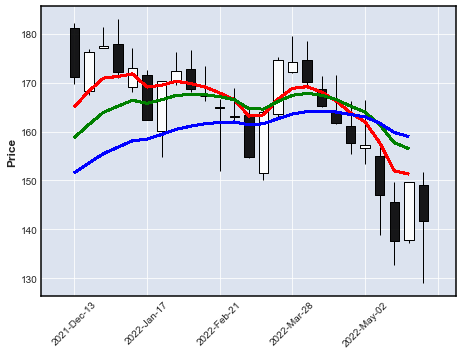

,Open,High,Low,Close,EMA6,EMA12,EMA24,labels,prediction,Datetime,profit,trade
In,,,,,,,,,,,,
350,181.119995,182.130005,169.690002,171.139999,165.054890,158.731920,151.566326,nn,nn,2021-12-13,-7.410004,15
351,168.279999,176.850006,167.460007,176.279999,168.262064,161.431624,153.543420,nn,nn,2021-12-20,-7.410004,15
352,177.089996,181.330002,177.070007,177.570007,170.921477,163.914453,155.465547,nn,nn,2021-12-27,-7.410004,15
353,177.830002,182.940002,171.029999,172.169998,171.278197,165.184536,156.801903,nn,nn,2022-01-03,-7.410004,15
354,169.080002,177.179993,168.169998,173.070007,171.790143,166.397686,158.103352,nn,nn,2022-01-10,-7.410004,15
355,171.509995,172.539993,162.300003,162.410004,169.110103,165.784196,158.447884,nn,nn,2022-01-17,-7.410004,15
356,160.020004,170.350006,154.699997,170.330002,169.458646,166.483551,159.398453,nn,nn,2022-01-24,-7.410004,15
357,170.160004,176.240005,169.509995,172.389999,170.296175,167.392235,160.437777,nn,nn,2022-01-31,-7.410004,15
358,172.860001,176.649994,168.039993,168.639999,169.822982,167.584199,161.093955,nn,nn,2022-02-07,-7.410004,15


In [17]:
trade = 15
from plotting import PlotTrade

df = PlotTrade(trade=trade,trades_df=trades_df,window_size=window_size,entry_candle=entry_candle,budget=budget)
trade += 1
df


In [18]:
from final_evaluation import GetPerformanceReport

GetPerformanceReport = GetPerformanceReport()

GetPerformanceReport.fit(entry_candle="Current Open",
                        budget=10000,
                        window_size=25,
                        export_excel=True,
                        excel_path = excel_reports)

trades_df_final = GetPerformanceReport.transform(trades_df)
trades_df_final


--------> GetPerformanceReport completed



,Open,High,Low,Close,EMA6,EMA12,EMA24,labels,prediction,Datetime,profit,trade,Entry,Performance
0,154.970001,157.259995,148.699997,148.970001,148.978732,145.446614,139.562798,nn,nn,2021-09-06,-1.000000,1,nn,nn
1,150.630005,151.419998,145.759995,146.059998,148.144808,145.540981,140.082574,nn,nn,2021-09-13,-1.000000,1,nn,nn
2,143.800003,147.470001,141.270004,146.919998,147.794862,145.753137,140.629568,nn,nn,2021-09-20,-1.000000,1,nn,nn
3,145.470001,145.960007,139.110001,142.649994,146.324900,145.275730,140.791202,nn,nn,2021-09-27,-1.000000,1,nn,nn
4,141.759995,144.220001,138.270004,142.899994,145.346355,144.910233,140.959905,nn,nn,2021-10-04,-1.000000,1,nn,nn
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
545,133.419998,141.910004,133.320007,141.660004,141.834333,147.788278,153.248825,nn,nn,2022-06-20,21.360001,22,nn,nn
546,142.699997,143.490005,133.770004,138.929993,141.004521,146.425465,152.103319,nn,nn,2022-06-27,21.360001,22,nn,nn
547,137.770004,147.550003,136.929993,147.039993,142.728942,146.520008,151.698253,nn,nn,2022-07-04,21.360001,22,nn,nn
548,145.669998,150.860001,142.119995,150.169998,144.854958,147.081545,151.575992,nn,nn,2022-07-11,21.360001,22,nn,nn


In [21]:
from final_evaluation import MakeSinglePrediction

#split_ratio = 0.8

model_name = f'{saved_models}/{str.upper(ticker)}_{formation_window}_{target_window}_{window_size}_{split_ratio}_{start_date}_{end_date}.h5'

MakeSinglePrediction = MakeSinglePrediction()

fit_output = MakeSinglePrediction.fit(
                        model_name=model_name,
                        form_window=24,
                        ticker=ticker,
                        start_date="2021-03-18",
                        end_date="2022-08-21",
                        interval='1wk',
                        progress=False,
                        condition=False,
                        timeperiod1=6,
                        timeperiod2=12,
                        timeperiod3=24,
                        debug=False,
                        budget=10000,
                        penalization=0,
                        acceptance=0,
                        entry_candle='Current Close')

#fit method outputs tuple, get only trade formation out of tuple
trade_formation = fit_output[1]
final_trade_formation = trade_formation.head(24)
final_trade_formation
###IMPORTANT!!!!
#trade_formation dataframe must be checked before transformation, sometimes df pulled via yahoo finance 
# is shifted, and trade formation does not have entire formation in itself. in this case there must 
# be changed end_date in fit method

MakeSinglePrediction.transform(final_trade_formation)



1/1 [==============================] - 2s 2s/step

Entry candle (Current Close)

Budget:  10000

Entry price:  171.52
Prediction:  171.9
Expected Profit:  22.31


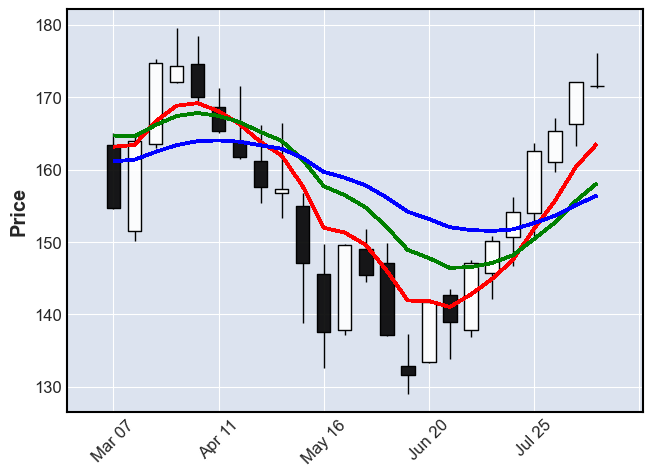

In [22]:
from plotting import PlotCurrentFormation

PlotCurrentFormation(final_trade_formation)